In [7]:
# from bao import *
from static import *
from stock_data import *
from backtest import *
from efficient_frontier import summary_market
from icecream import ic
from capm_func import *

with open(PATH_DICTIONARY, "r") as a:
    name_dict = json.load(a)

* **I would like to build 10 portfolios that with specific return and give back portfolio allocation with best variance**
* **Then testing stategy that following best variance through out the posible time**
* **Time for train is 1 year and result applying is also 1 year**

In [8]:
stock = StockData("./data/stock/", "./stock_dictionary.json")
stock_data = stock.get_data()
with open(PATH_INDEX, "r") as a:
    index_l = json.load(a)
stock_data.drop(columns=["symbol"], inplace=True)

In [9]:
market_df = stock_data[
    (stock_data["market_value"] > 0)
    & (stock_data["ticker"].str.len() == 3)
    & (stock_data["ticker"].isin(index_l["VN100"]))
][["ticker", "market_value", "log_return", "time", "exchange"]].dropna(subset=["log_return"])
market_df_stat, market_df = summary_market(market_df)

# Test VN30 stock

In [10]:
results, beta = tracking(stock_data, stock_list=index_l["VN30"], num_portfolios=16)

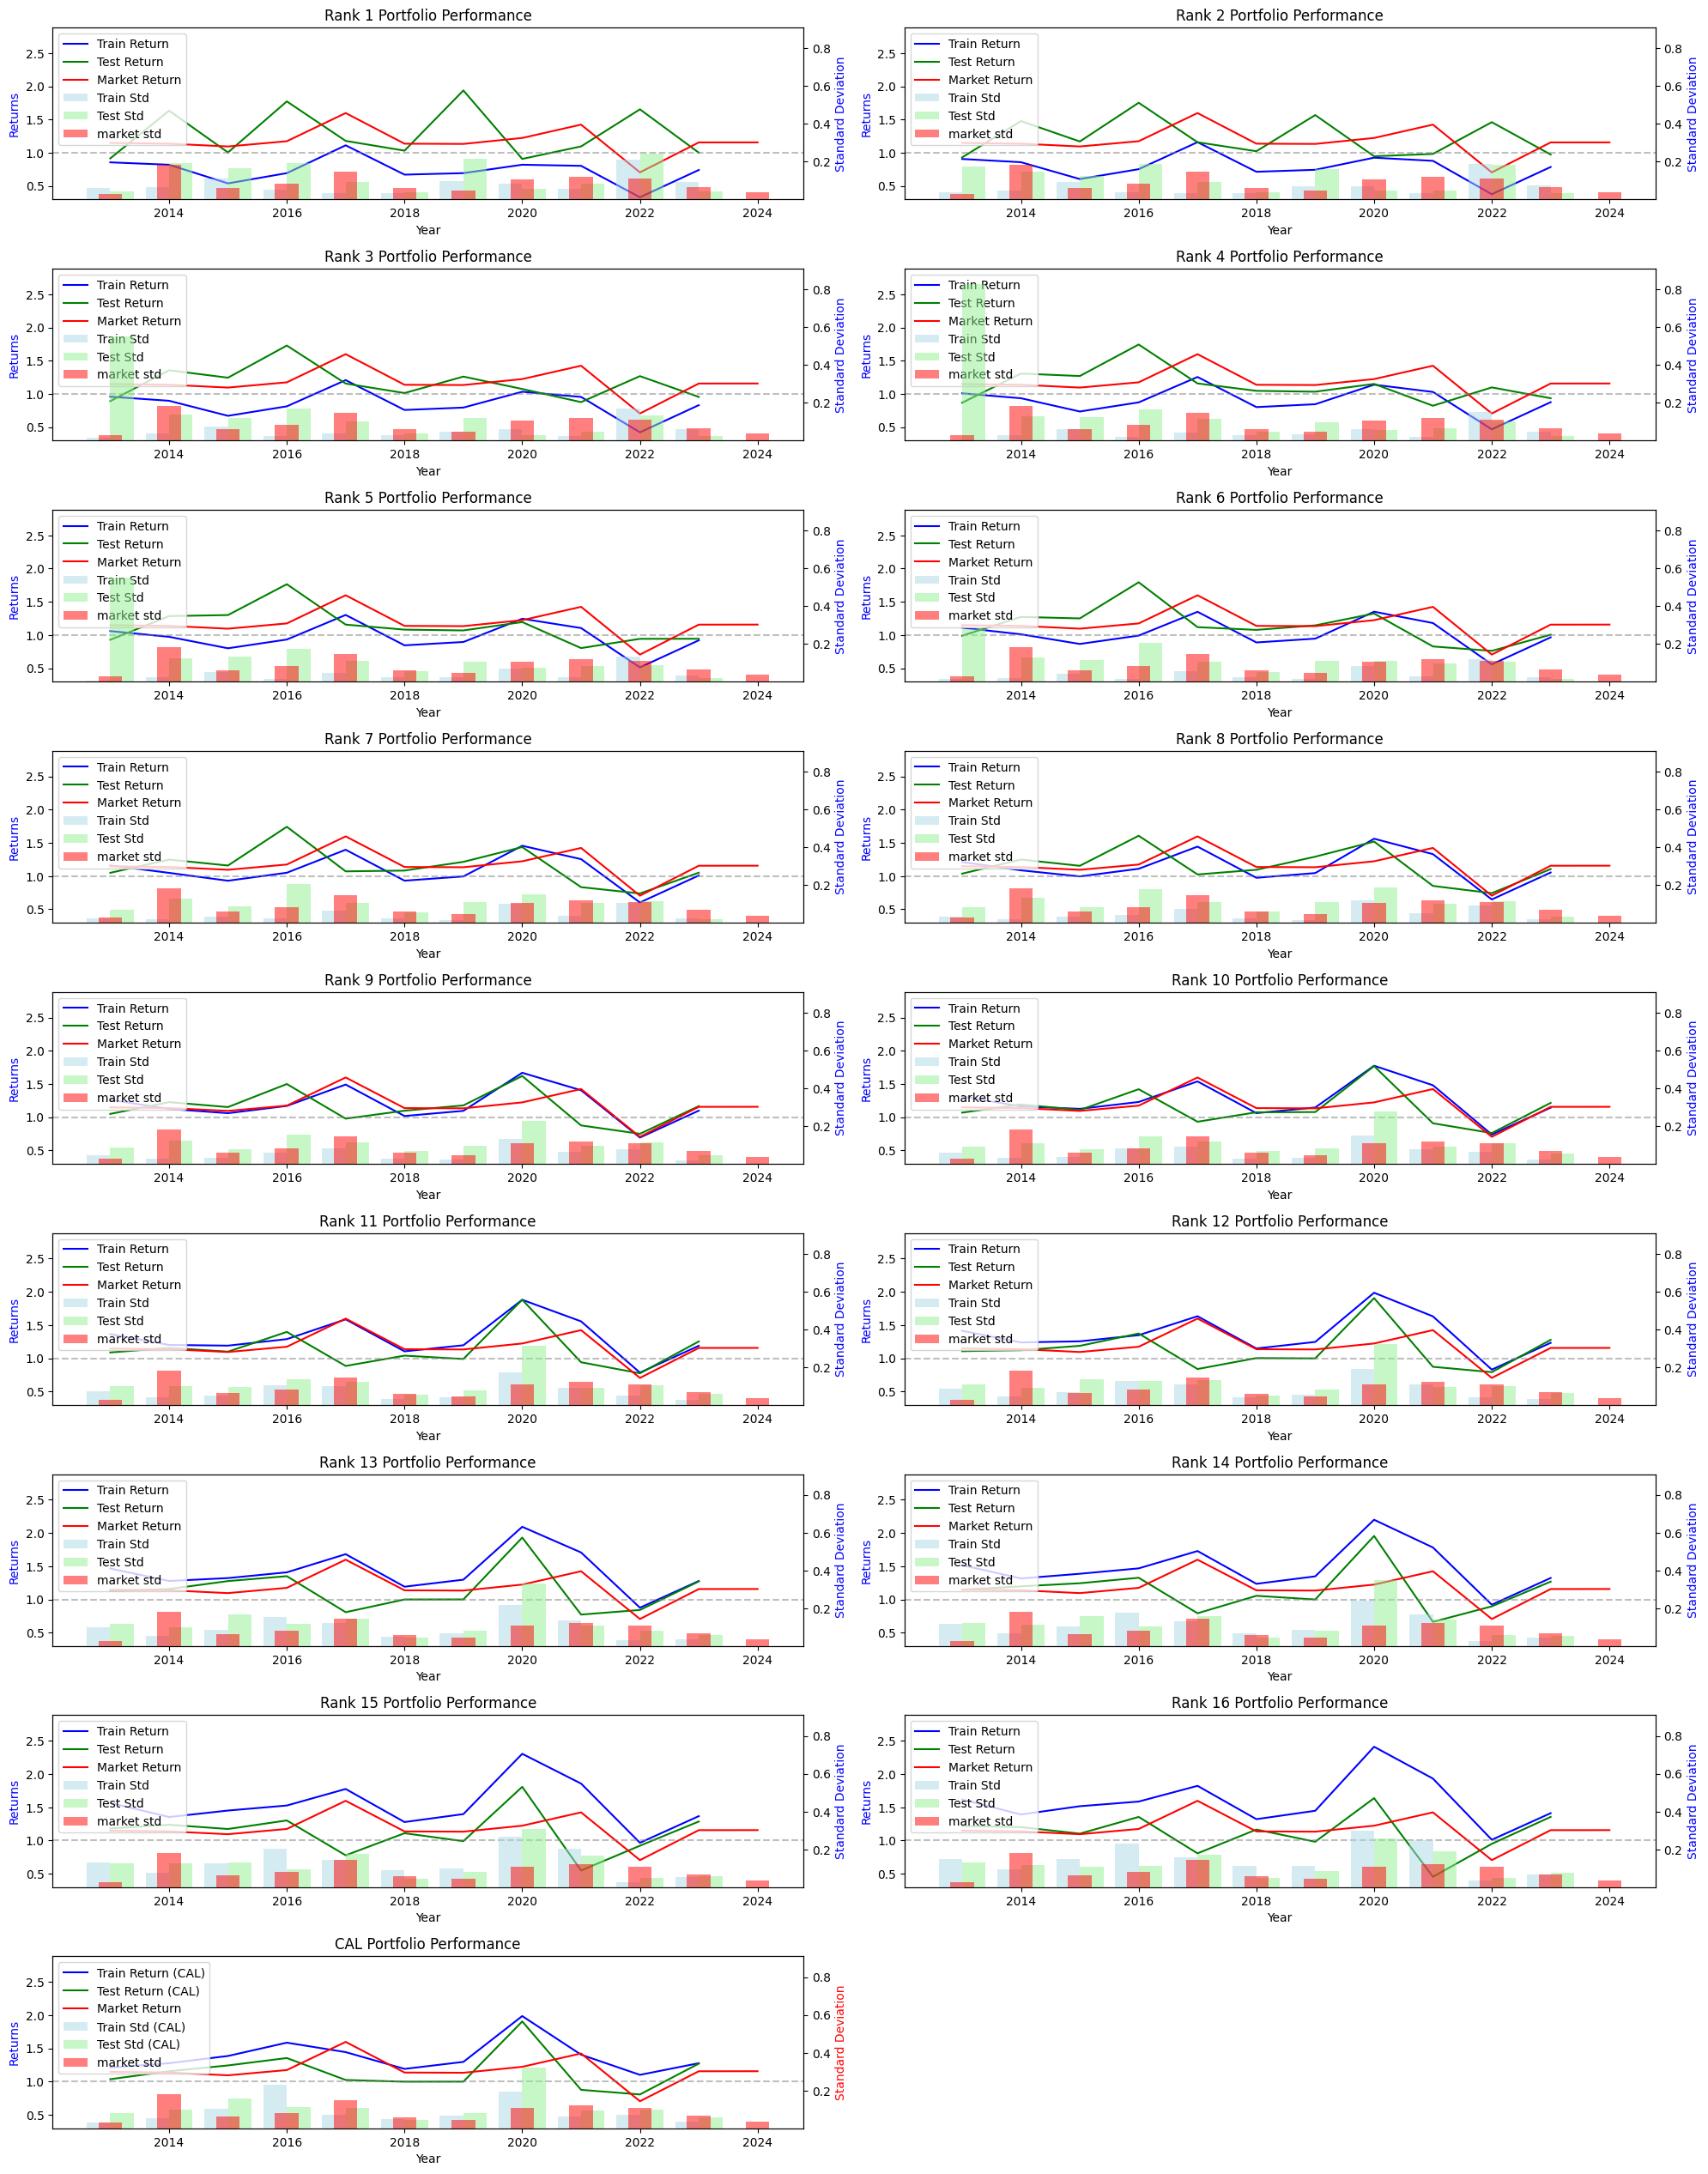

In [11]:
plot_backtest_stategy(results, market_df_stat, num_portfolios=16)

In [12]:
df_list = [pd.concat([i[i["port"] == j] for i in beta]) for j in range(1, 16)]

In [14]:
df_list[0]

,time,train,test,year,port
0,2016-01-04,0.952567,NaN,2016,1
1,2016-01-05,0.947648,NaN,2016,1
2,2016-01-06,0.952851,NaN,2016,1
3,2016-01-07,0.914088,NaN,2016,1
4,2016-01-08,0.891678,NaN,2016,1
...,...,...,...,...,...
494,2016-12-26,NaN,1.178784,2015,1
495,2016-12-27,NaN,1.167821,2015,1
496,2016-12-28,NaN,1.172485,2015,1
497,2016-12-29,NaN,1.167474,2015,1


In [49]:
result = []
risk_free_rate = 0.05
for j, i in enumerate(df_list):
    train = i[i["train"].notna()]
    test = i[i["test"].notna()]
    train = train.merge(market_df[["time", "market_log_return"]], on="time", how="inner")
    test = test.merge(market_df[["time", "market_log_return"]], on="time", how="inner")
    for year in train.year.unique():
        train_returns = train[train["year"] == year]["train"]
        test_returns = test[test["year"] == year]["test"]
        window_market_train = train[train["year"] == year]["market_log_return"]
        window_market_test = test[test["year"] == year]["market_log_return"]
        beta_train = np.cov(train_returns, window_market_train)[0, 1] / np.var(window_market_train)
        beta_test = np.cov(test_returns, window_market_test)[0, 1] / np.var(window_market_test)
        market_risk_premium_train = window_market_train.iloc[-1] - risk_free_rate
        market_risk_premium_test = window_market_test.iloc[-1] - risk_free_rate
        actual_return_train = train_returns.iloc[-1]
        actual_return_test = test_returns.iloc[-1]
        result.append(
            pd.DataFrame(
                {
                    "port": [j],
                    "beta_train": [beta_train],
                    "beta_test": [beta_test],
                    "year": [year],
                    "market_risk_premium_train": [market_risk_premium_train],
                    "market_risk_premium_test": [market_risk_premium_test],
                    "actual_return_train": [actual_return_train],
                    "actual_return_test": [actual_return_test],
                }
            )
        )
        # Calculate CAPM expected return

In [50]:
result = pd.concat(result)

In [51]:
result.sort_values("year", ascending=True)

,port,beta_train,beta_test,year,market_risk_premium_train,market_risk_premium_test,actual_return_train,actual_return_test
0,0,-0.092906,0.907823,2013,1.097671,1.087008,0.906623,0.929919
0,1,-0.042413,2.908590,2013,1.097671,1.087008,0.957374,0.890237
0,2,0.029350,4.358092,2013,1.097671,1.087008,1.008125,0.866679
0,3,0.212646,2.918070,2013,1.097671,1.087008,1.058876,0.927546
0,4,0.396015,1.478412,2013,1.097671,1.087008,1.109626,0.988408
...,...,...,...,...,...,...,...,...
0,10,0.300846,1.367223,2023,1.105814,1.106409,1.232522,1.277795
0,13,0.536860,1.246380,2023,1.105814,1.106409,1.366597,1.285734
0,11,0.365064,1.263401,2023,1.105814,1.106409,1.277214,1.271076
0,12,0.446312,1.189267,2023,1.105814,1.106409,1.321905,1.267304



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


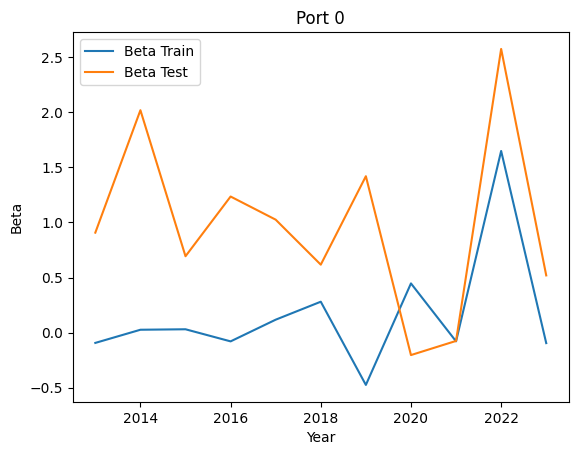

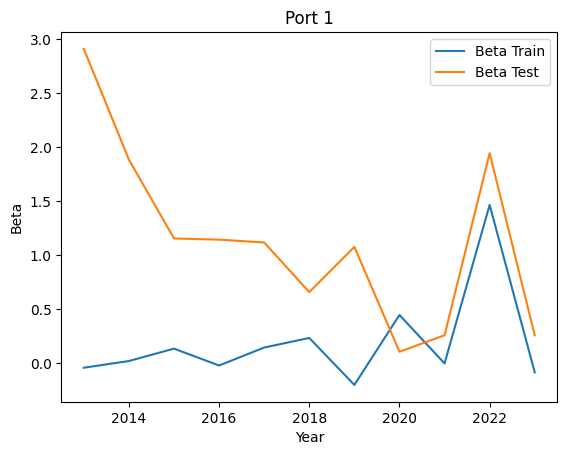

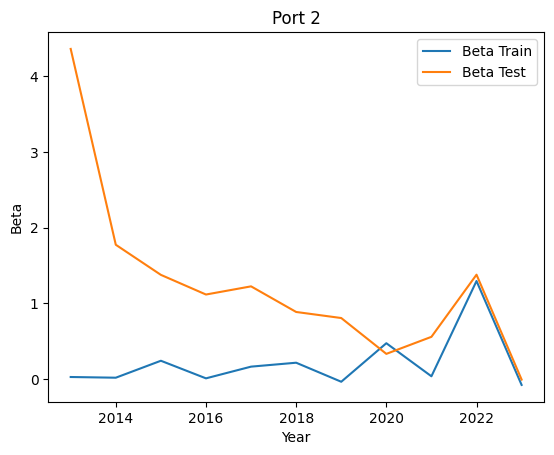

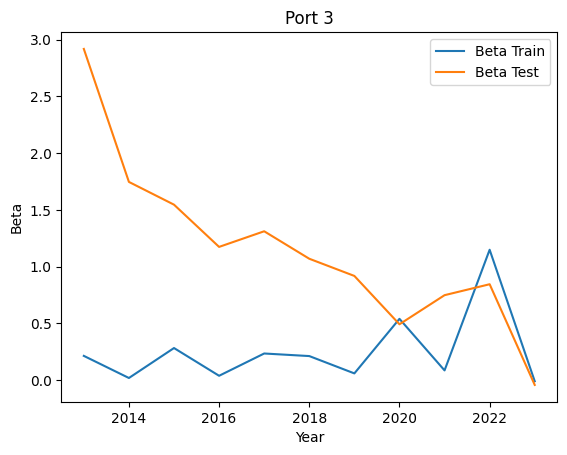

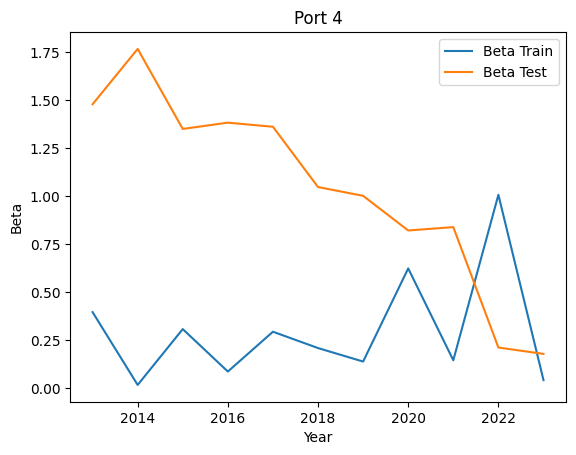

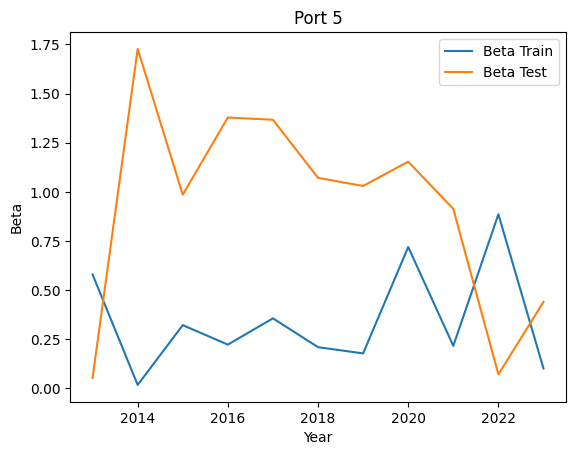

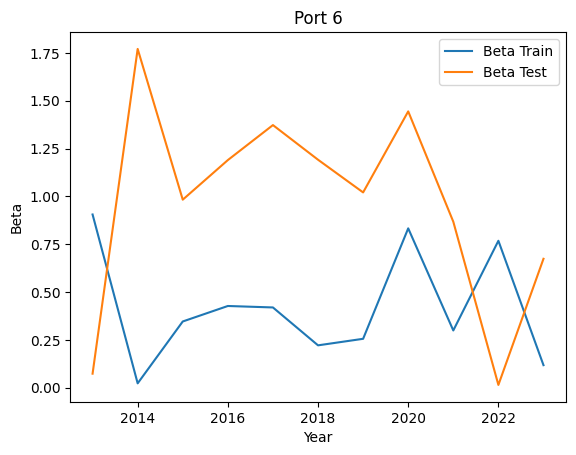

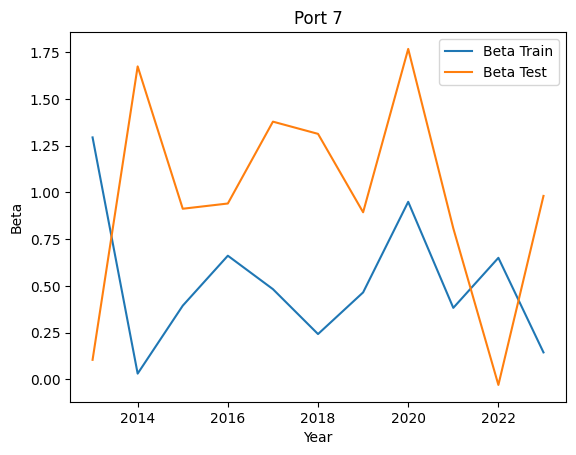

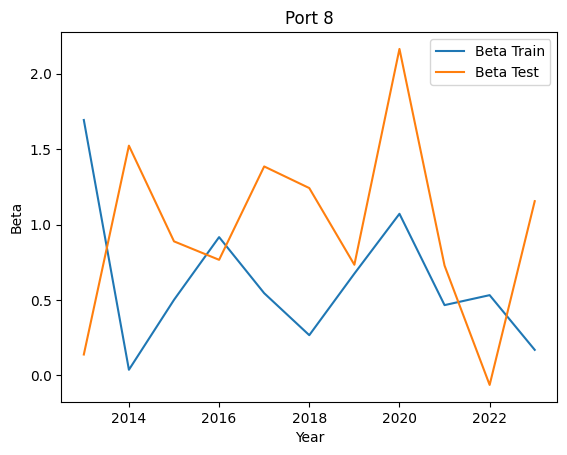

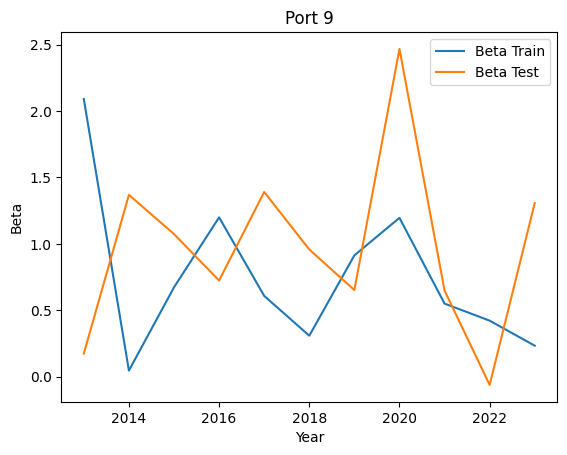

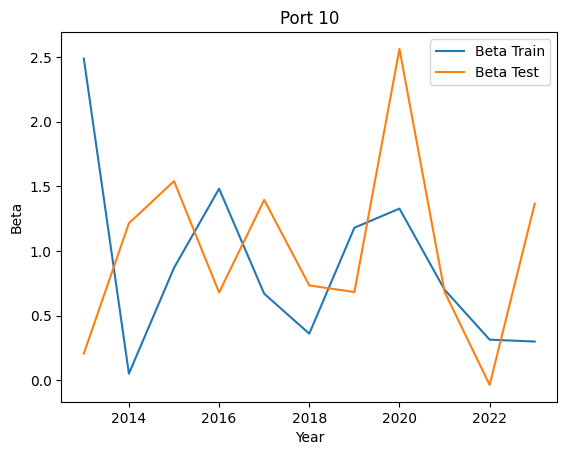

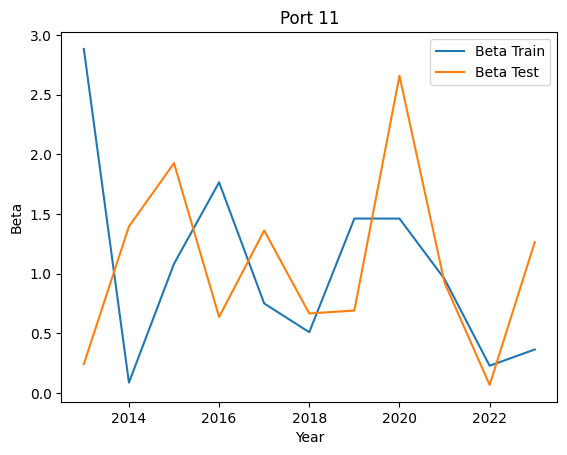

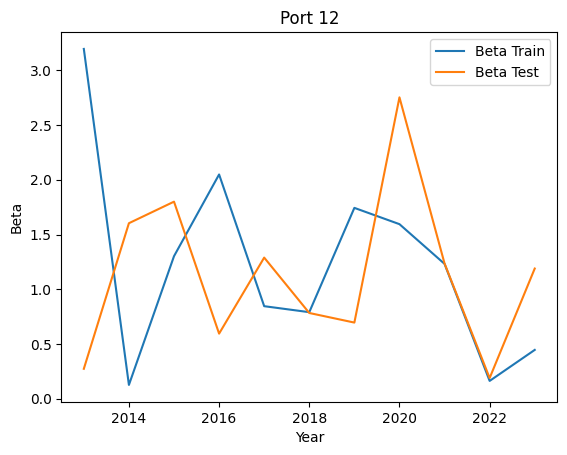

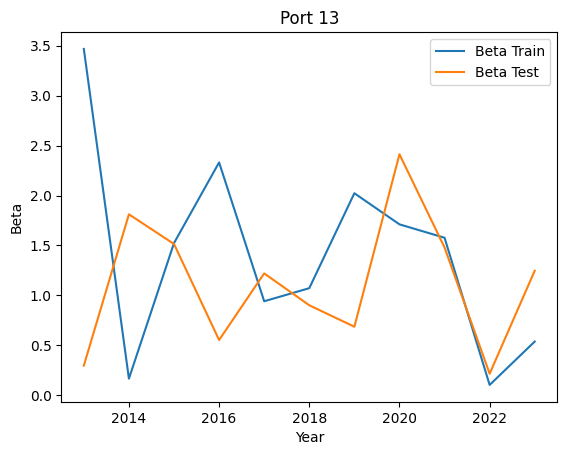

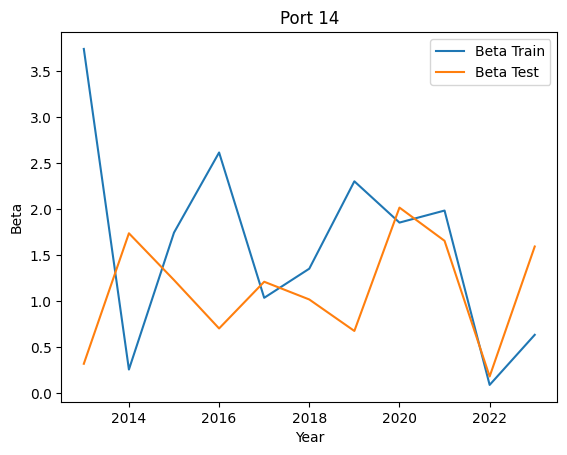

In [44]:
import matplotlib.pyplot as plt

ports = result["port"].unique()
for port in ports:
    port_data = result[result["port"] == port]
    plt.figure()
    port_data.sort_values("year", ascending=True, inplace=True)
    plt.plot(port_data["year"], port_data["beta_train"], label="Beta Train")
    plt.plot(port_data["year"], port_data["beta_test"], label="Beta Test")
    plt.xlabel("Year")
    plt.ylabel("Beta")
    plt.title(f"Port {port}")
    plt.legend()
    plt.show()

## ttest for comparing train and test: return and volatility


=== Portfolio Statistical Tests Results ===



,category,hypothesis,t_statistic,p_value,conclusion,significance
Returns (Test ≤ Train),Returns,H₀: test_return ≤ train_return,-2.1341,0.0167,Reject,Significant
Volatility (Test ≥ Train),Volatility,H₀: test_std ≥ train_std,4.3860,0.0000,Reject,Significant
Returns (Test > Train),Returns,H₀: test_return > train_return,-2.1341,0.9833,Fail to reject,Not significant
Volatility (Test < Train),Volatility,H₀: test_std < train_std,4.3860,1.0000,Fail to reject,Not significant
Returns Equality,Returns,H₀: test_return = train_return,-2.1341,0.0335,Reject,Significant
Volatility Equality,Volatility,H₀: test_std = train_std,4.3860,0.0000,Reject,Significant


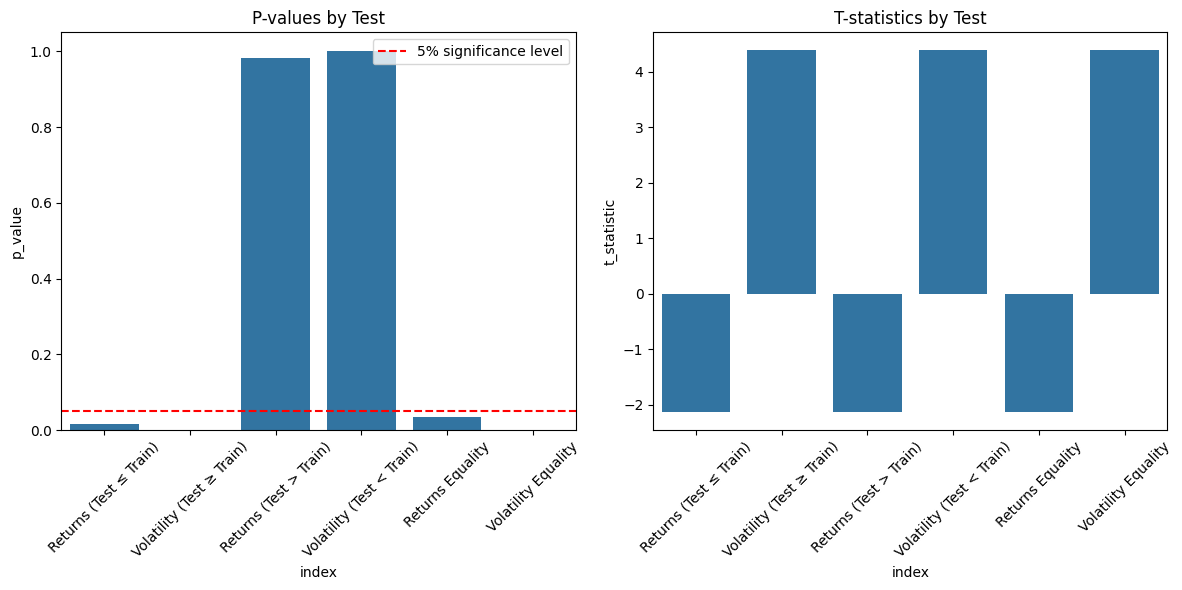

In [5]:
test_results = perform_portfolio_tests(results)

# Vn100 stock

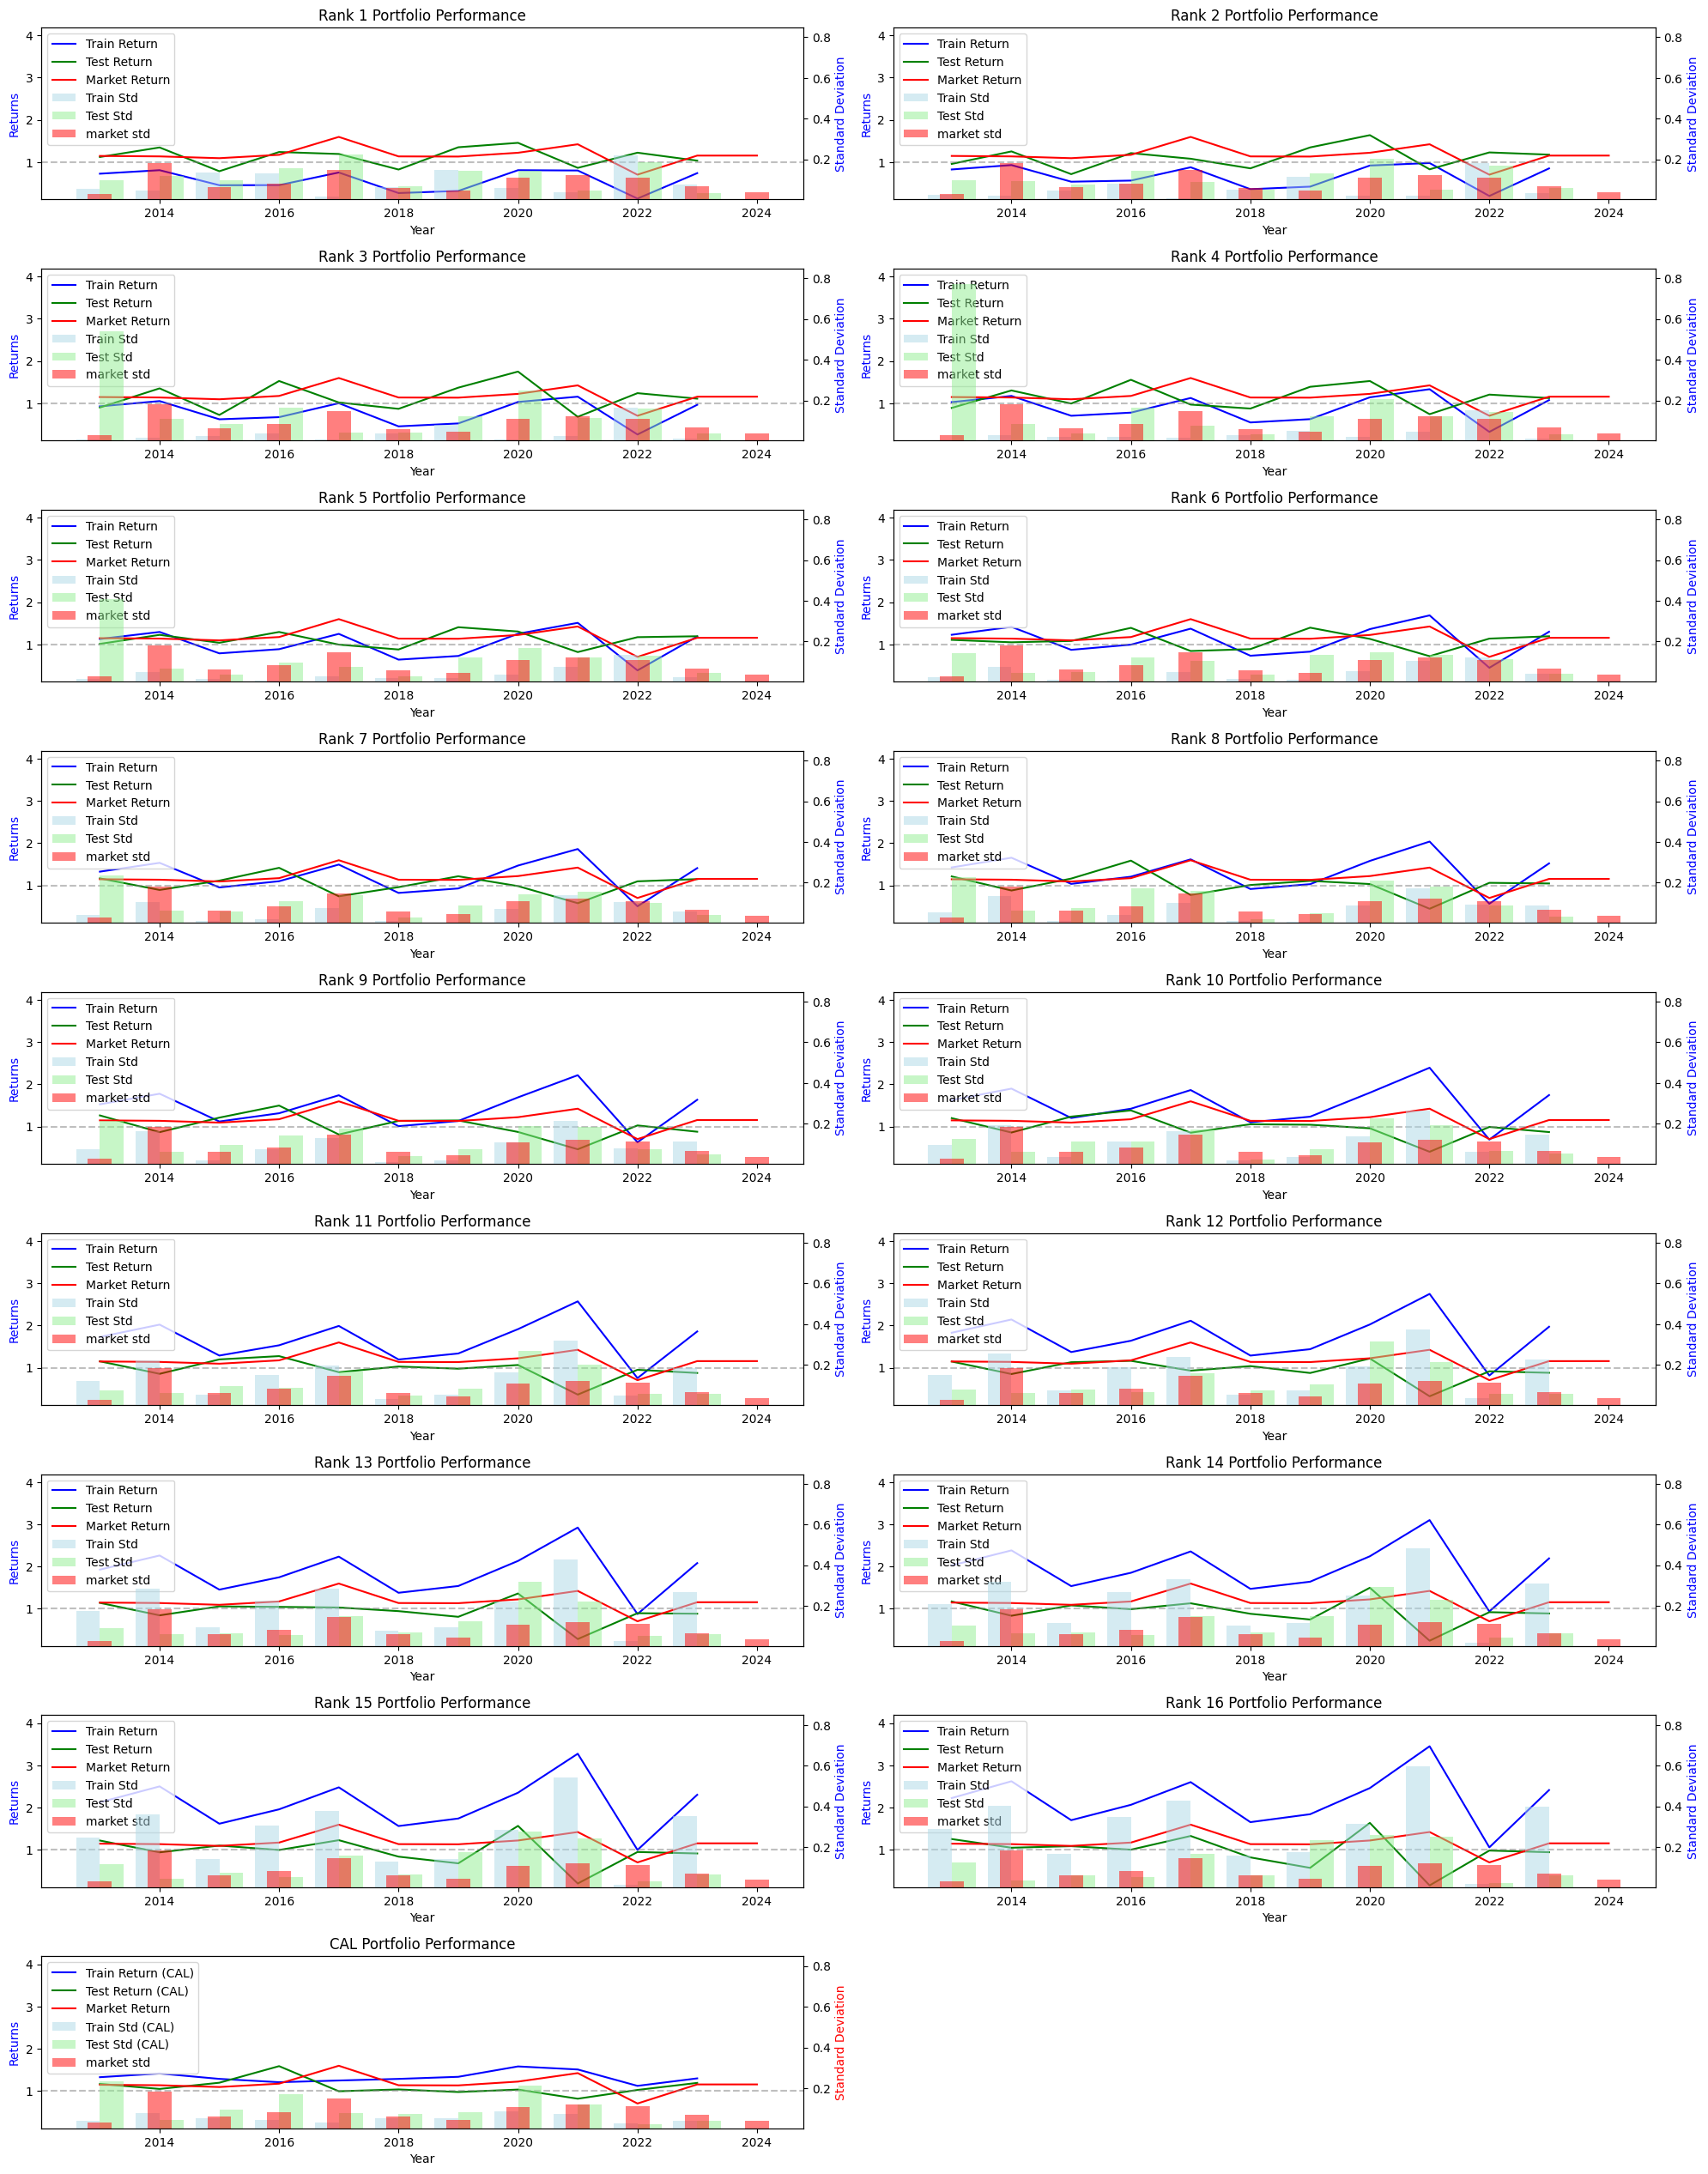

In [6]:
results = tracking(stock_data, stock_list=index_l["VN100"], num_portfolios=16)

plot_backtest_stategy(results, market_df_stat, num_portfolios=16)


=== Portfolio Statistical Tests Results ===



,category,hypothesis,t_statistic,p_value,conclusion,significance
Returns (Test ≤ Train),Returns,H₀: test_return ≤ train_return,-8.2290,0.0000,Reject,Significant
Volatility (Test ≥ Train),Volatility,H₀: test_std ≥ train_std,-2.2941,0.9888,Fail to reject,Not significant
Returns (Test > Train),Returns,H₀: test_return > train_return,-8.2290,1.0000,Fail to reject,Not significant
Volatility (Test < Train),Volatility,H₀: test_std < train_std,-2.2941,0.0112,Reject,Significant
Returns Equality,Returns,H₀: test_return = train_return,-8.2290,0.0000,Reject,Significant
Volatility Equality,Volatility,H₀: test_std = train_std,-2.2941,0.0223,Reject,Significant


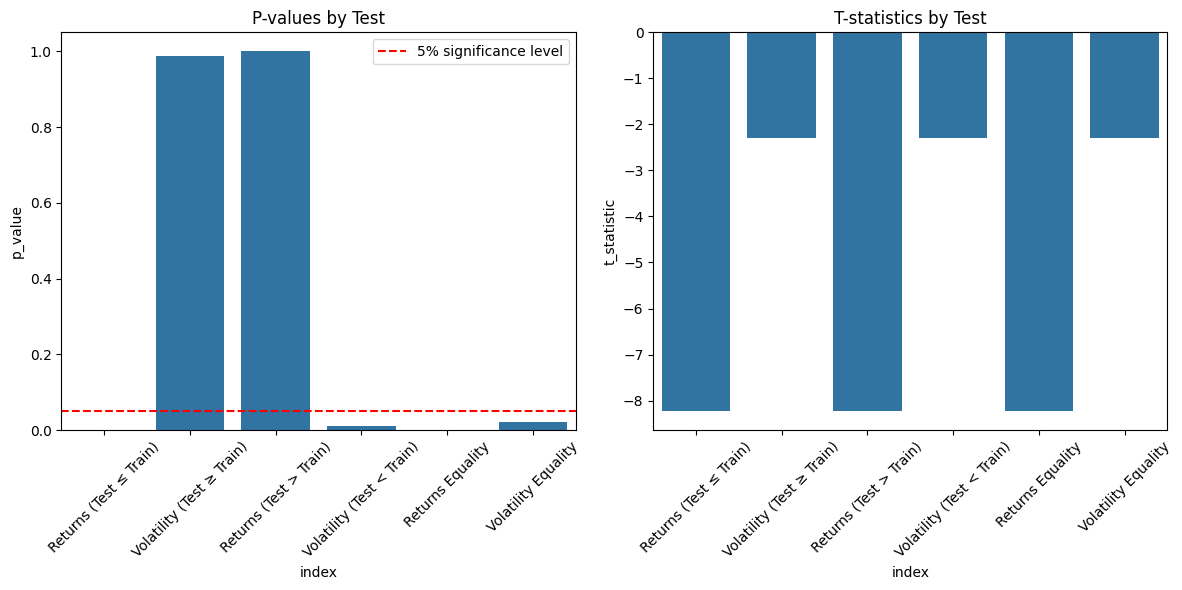

In [7]:
test_results = perform_portfolio_tests(results)